In [61]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [62]:
# Load your data
df = pd.read_csv('data/Davis.csv', parse_dates=['date'])
df.set_index('date', inplace=True)
df = df.drop(['Unnamed: 0', 'hospital'], axis=1)
df.dropna(inplace=True, axis=1) #This drops two engineered columns that contain Na values
print('Number of Na Values: ', df.isna().sum().sum())

Number of Na Values:  0


In [63]:
# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

In [64]:
dfs = pd.DataFrame(scaled_features, columns=df.columns, index=df.index)
dfs.isna().sum().sum()
print('Number of Na Values in scaled data: ', df.isna().sum().sum())

Number of Na Values in scaled data:  0


In [65]:
#inspecting scaled data
dfs.head(5)

,year,monthday,month,day,attendences,min,max,aver,Hosp_ID,Time_ID,...,Nov,Dec,Year_1,Year_2,Year_3,Year_4,Year_5,Year_6,Year_7,Year_8
date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,-1.527874,-1.643186,-1.601451,-1.673805,-0.603759,-1.030909,-2.101145,-1.758875,0.0,-1.731458,...,-0.299141,-0.304541,2.646787,-0.377817,-0.377817,-0.378408,-0.377817,-0.377817,-0.377817,-0.378408
2009-01-02,-1.527874,-1.640288,-1.601451,-1.560170,-0.151734,-1.218745,-1.748473,-1.451143,0.0,-1.730273,...,-0.299141,-0.304541,2.646787,-0.377817,-0.377817,-0.378408,-0.377817,-0.377817,-0.377817,-0.378408
2009-01-03,-1.527874,-1.637390,-1.601451,-1.446535,-0.916700,-1.594415,-1.513359,-1.605009,0.0,-1.729087,...,-0.299141,-0.304541,2.646787,-0.377817,-0.377817,-0.378408,-0.377817,-0.377817,-0.377817,-0.378408
2009-01-04,-1.527874,-1.634492,-1.601451,-1.332899,-1.612123,-2.533592,-1.630916,-2.066607,0.0,-1.727902,...,-0.299141,-0.304541,2.646787,-0.377817,-0.377817,-0.378408,-0.377817,-0.377817,-0.377817,-0.378408
2009-01-05,-1.527874,-1.631594,-1.601451,-1.219264,-0.708073,-0.843074,-1.983588,-1.605009,0.0,-1.726716,...,-0.299141,-0.304541,2.646787,-0.377817,-0.377817,-0.378408,-0.377817,-0.377817,-0.377817,-0.378408


In [66]:
# Define test_size as a proportion of the dataset
test_size = 0.2
test_size = int(len(scaled_features) * test_size)

# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length][4]  # Target is the 5th column
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 365  # Given the long term trends, we will use a year of data to make predictions. 

# Create sequences for the whole dataset
X, y = create_sequences(scaled_features, seq_length)

# Split into training and testing sets
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [67]:
import torch.nn as nn

class TransformerEncoderModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim, dropout=0.1):
        super(TransformerEncoderModel, self).__init__()
        self.model_dim = model_dim
        self.embedding = nn.Linear(input_dim, model_dim)
        
        encoder_layers = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        
        self.fc_out = nn.Linear(model_dim, output_dim)

    def forward(self, src):
        src = self.embedding(src) * np.sqrt(self.model_dim)
        src = src.permute(1, 0, 2)  # Transformer expects input shape (sequence_length, batch_size, model_dim)
        transformer_output = self.transformer_encoder(src)
        output = self.fc_out(transformer_output[-1, :, :])
        return output

input_dim = X_train.shape[2]
model_dim = 64
num_heads = 4
num_layers = 3
output_dim = 1

model = TransformerEncoderModel(input_dim, model_dim, num_heads, num_layers, output_dim)



c:\Users\kentm\anaconda3\envs\TTS1_0\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [68]:
import torch.optim as optim

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
model.train()
for epoch in range(num_epochs):
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')



Epoch 1/20, Loss: 0.2576
Epoch 2/20, Loss: 0.3898
Epoch 3/20, Loss: 0.4747
Epoch 4/20, Loss: 0.3755
Epoch 5/20, Loss: 0.2150
Epoch 6/20, Loss: 0.4744
Epoch 7/20, Loss: 0.3540
Epoch 8/20, Loss: 0.2656
Epoch 9/20, Loss: 0.4051
Epoch 10/20, Loss: 0.2236
Epoch 11/20, Loss: 0.1831
Epoch 12/20, Loss: 0.3675
Epoch 13/20, Loss: 0.3474
Epoch 14/20, Loss: 0.3729
Epoch 15/20, Loss: 0.1778
Epoch 16/20, Loss: 0.1765
Epoch 17/20, Loss: 0.2536
Epoch 18/20, Loss: 0.3210
Epoch 19/20, Loss: 0.1718
Epoch 20/20, Loss: 0.1777


In [69]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).squeeze()
    test_loss = criterion(predictions, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')


Test Loss: 0.8328


In [88]:
# Ensure the model is in evaluation mode
model.eval()

# Make predictions for the training set to calculate residuals
with torch.no_grad():
    train_predictions = model(X_train_tensor).squeeze().numpy()

# Calculate residuals (errors) on the training set
residuals = y_train_tensor.numpy() - train_predictions

# Calculate the standard deviation of the residuals in the original scale
# Inverse transform the predictions first
train_predictions_original_scale = scaler_target.inverse_transform(train_predictions.reshape(-1, 1)).reshape(-1)
y_train_original_scale = scaler_target.inverse_transform(y_train_tensor.numpy().reshape(-1, 1)).reshape(-1)

# Calculate residuals in the original scale
residuals_original_scale = y_train_original_scale - train_predictions_original_scale

# Calculate the standard deviation of the residuals in the original scale
residuals_std_original_scale = np.std(residuals_original_scale)

# Define a function to calculate confidence intervals
def calculate_confidence_intervals(pred, confidence_level=1.96):
    upper_bound = pred + (confidence_level * residuals_std_original_scale)
    lower_bound = pred - (confidence_level * residuals_std_original_scale)
    return upper_bound, lower_bound

# Define the number of days in the first month of the test set (assuming 28 days)
first_month_days = 28

# Make predictions for the first month of the test set
with torch.no_grad():
    predictions_first_month = model(X_test_tensor[:first_month_days]).squeeze().numpy()

# Inverse transform predictions and actual values to the original scale
predictions_first_month_original_scale = scaler_target.inverse_transform(predictions_first_month.reshape(-1, 1)).reshape(-1)
y_test_first_month_original_scale = scaler_target.inverse_transform(y_test_tensor[:first_month_days].numpy().reshape(-1, 1)).reshape(-1)

# Calculate confidence intervals
upper_bound, lower_bound = calculate_confidence_intervals(predictions_first_month_original_scale)

# Get the dates for the first month of the test set
dates_first_month = df.index[-test_size:][:first_month_days]

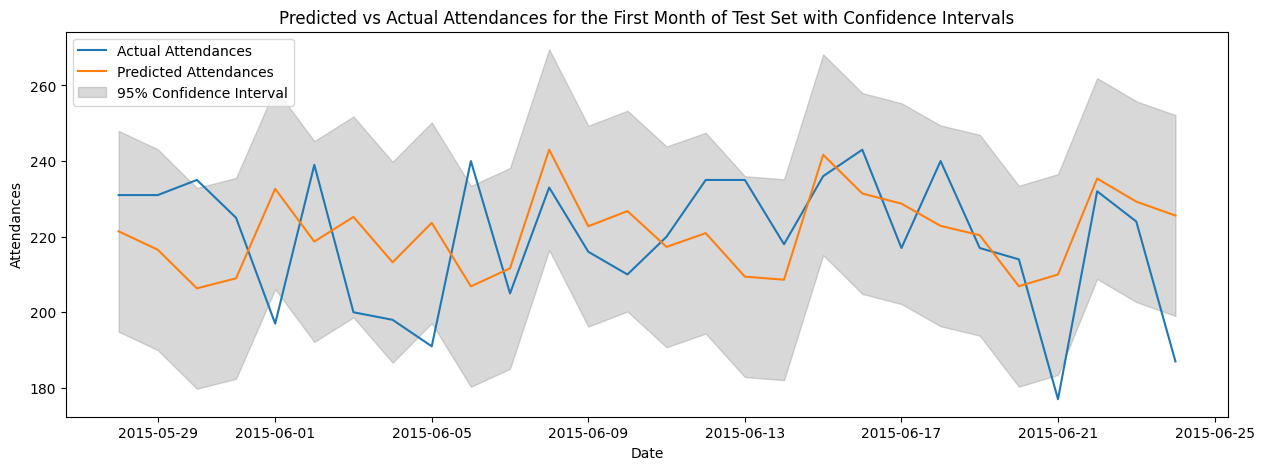

In [89]:
# Plotting the results with confidence intervals
plt.figure(figsize=(15, 5))
plt.plot(dates_first_month, y_test_first_month_original_scale, label='Actual Attendances')
plt.plot(dates_first_month, predictions_first_month_original_scale, label='Predicted Attendances')
plt.fill_between(dates_first_month, lower_bound, upper_bound, color='gray', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Attendances')
plt.title('Predicted vs Actual Attendances for the First Month of Test Set with Confidence Intervals')
plt.legend()
plt.show()


In [ ]:
#TODO: Add holidays
#TODO: Augment weather data
#TODO: Add regional search data?
#TODO: Add flu/covid data?
#TODO: Add pollen count, air quality?
